In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
n = 20000 # iteraciones
dt = 0.001
desfase = 5
e1 = []
e3 = []
e5 = []
ek1 = []
ek3 = []
ek5 = []
ek_1 = np.array([[0,0,0]])
for i in range(n+desfase):
    a = np.array([[0,0,0]])
    ek_1 = np.concatenate((ek_1,a))
ak_1 = ek_1

In [2]:
# Perturbacion
p = np.array([[0,0,0,0,0,0,0,0,0]])
limite = 0.002
for i in range(n-1):
    lst = [random.uniform(-limite,limite) for _ in range(9)]
    a = np.array([[lst[0],lst[1],lst[2],lst[3],lst[4],lst[5],lst[6],lst[7],lst[8]]])
    p = np.concatenate((p,a))

In [3]:
# Sistema
def sistema(x,p,tau):
    # parametros
    m1 = 0.066
    m2 = 0.0792
    m3 = 0.0792
    l1 = 0.25
    l2 = 0.3
    l3 = 0.3
    lc1 = l1/2
    lc2 = l2/2
    lc3 = l3/2
    I1 = 0.00138
    I2 = 0.00238
    I3 = 0.00338
    b = 0.1
    g = 9.81

    a1 = m1*lc1**2+(m2+m3)*l1**2+I1
    a2 = m2*lc2**2+m3*l2**2+I2
    a3 = m3*lc3**2+I3
    a4 = m2*l1*lc2+m3*l1*l2
    a5 = m3*l1*lc3
    a6 = m3*l2*lc3
    a7 = m1*lc1+(m2+m3)*l1
    a8 = m2*lc2+m3*l2
    a9 = m3*lc3

    # perturbacion
    p = 0.2 * p
    a1 = a1 + p[0]
    a2 = a2 + p[1]
    a3 = a3 + p[2]
    a4 = a4 + p[3]
    a5 = a5 + p[4]
    a6 = a6 + p[5]
    a7 = a7 + p[6]
    a8 = a8 + p[7]
    a9 = a9 + p[8]
    
    # variables de estado
    x1 = x[0,0]
    x2 = x[1,0]
    x3 = x[2,0]
    x4 = x[3,0]
    x5 = x[4,0]
    x6 = x[5,0]

    # Matrices del sistema
    c1 = np.cos(x1)
    c13 = np.cos(x1+x3)
    c135 = np.cos(x1+x3+x5)
    G1 = a7*c1+a8*c13+a9*c135
    G2 = a8*c13+a9*c135
    G3 = a9*c135
    G = g*np.array([[G1],[G2],[G3]])

    s1 = np.sin(x1)
    s3 = np.sin(x3)
    s5 = np.sin(x5)
    s35 = np.sin(x3+x5)
    C11, C22, C33 = 0, 0, 0
    C12 = -2*(a4*s1+a5*s35)*x2-(a4*s3+a5*s35)*x4-a5*s35*x6
    C21 = -(a4*s3+a5*s35)*x2+a5*s35*x6
    C13 = -2*(a5*s35+a6*s5)*x2-(a5*s35+2*a6*s5)*x4-(a5*s35+a6*s5)*x6
    C31 = (a5*s35+a6*s5)*x2+(a5*s35+2*a6*s5)*x4
    C23 = -(a5*s35+2*a6*s5)*x2-2*a6*s5*x4-a5*s5*x6
    C32 = -a5*s35*x2+a6*s5*x4
    C = np.array([[C11,C12,C13],[C21,C22,C23],[C31,C32,C33]])

    c3 = np.cos(x3)
    c5 = np.cos(x5)
    c35 = np.cos(x3+x5)
    M11 = a1+a2+a3+2*a4*c3+2*a5*c35+2*a6*c5
    M22 = a2+a3+2*a6*c5
    M33 = a3
    M12 = a2+a3+a4*c3+a5*c35+2*a6*c5
    M23 = a3+a5*c5
    M13 = a3+a5*c35+a6*c5
    M = np.array([[M11,M12,M13],[M12,M22,M23],[M13,M23,M33]])

    v = np.array([[x2],[x4],[x6]])
    u = tau - b * v
    iM = inv(M)

    xb = iM @ u - iM @ C @ v - iM @ G

    #sistema en la forma d/dt[x1;x2;x3;x4;x5;x6]=[f1;f2;f3;f4;f5;f6]
    dxdt = np.array([[x2],[xb[0,0]],[x4],[xb[1,0]],[x6],[xb[2,0]]])

    return dxdt

In [4]:
# Generador de trayectorias
def gen_trayectorias(xdi,xdf,xd,vd,ad,dt):
    xdf = xdf+100*dt*(xdi-xdf)
    ad = 10000*(xdf-xd)-200*vd
    vd = vd+dt*ad
    xd = xd+dt*vd
    return xd,vd,ad,xdf

In [5]:
def CTC(e,ep,qpp,x):
    #constantes del controlador
    kp = 40
    kv = 20
    # parametros
    m1 = 0.066
    m2 = 0.0792
    m3 = 0.0792
    l1 = 0.25
    l2 = 0.3
    l3 = 0.3
    lc1 = l1/2
    lc2 = l2/2
    lc3 = l3/2
    I1 = 0.00138
    I2 = 0.00238
    I3 = 0.00338
    b = 0.1
    g = 9.81

    a1 = m1*lc1**2+(m2+m3)*l1**2+I1
    a2 = m2*lc2**2+m3*l2**2+I2
    a3 = m3*lc3**2+I3
    a4 = m2*l1*lc2+m3*l1*l2
    a5 = m3*l1*lc3
    a6 = m3*l2*lc3
    a7 = m1*lc1+(m2+m3)*l1
    a8 = m2*lc2+m3*l2
    a9 = m3*lc3

    # variables de estado
    x1 = x[0,0]
    x2 = x[1,0]
    x3 = x[2,0]
    x4 = x[3,0]
    x5 = x[4,0]
    x6 = x[5,0]

    # Matrices del sistema
    c1 = np.cos(x1)
    c13 = np.cos(x1+x3)
    c135 = np.cos(x1+x3+x5)
    G1 = a7*c1+a8*c13+a9*c135
    G2 = a8*c13+a9*c135
    G3 = a9*c135
    G = g*np.array([[G1],[G2],[G3]])

    s1 = np.sin(x1)
    s3 = np.sin(x3)
    s5 = np.sin(x5)
    s35 = np.sin(x3+x5)
    C11, C22, C33 = 0, 0, 0
    C12 = -2*(a4*s1+a5*s35)*x2-(a4*s3+a5*s35)*x4-a5*s35*x6
    C21 = -(a4*s3+a5*s35)*x2+a5*s35*x6
    C13 = -2*(a5*s35+a6*s5)*x2-(a5*s35+2*a6*s5)*x4-(a5*s35+a6*s5)*x6
    C31 = (a5*s35+a6*s5)*x2+(a5*s35+2*a6*s5)*x4
    C23 = -(a5*s35+2*a6*s5)*x2-2*a6*s5*x4-a5*s5*x6
    C32 = -a5*s35*x2+a6*s5*x4
    C = np.array([[C11,C12,C13],[C21,C22,C23],[C31,C32,C33]])

    c3 = np.cos(x3)
    c5 = np.cos(x5)
    c35 = np.cos(x3+x5)
    M11 = a1+a2+a3+2*a4*c3+2*a5*c35+2*a6*c5
    M22 = a2+a3+2*a6*c5
    M33 = a3
    M12 = a2+a3+a4*c3+a5*c35+2*a6*c5
    M23 = a3+a5*c5
    M13 = a3+a5*c35+a6*c5
    M = np.array([[M11,M12,M13],[M12,M22,M23],[M13,M23,M33]])

    v = np.array([[x2],[x4],[x6]])

    tau = M@(qpp+kp*e+kv*ep)+C@v+G+b*v

    return tau

In [6]:
def ILC(ek,ek1,ak,akp,dt):
    L = 0.6*2
    Lek = L/dt*(ek1-ek)
    x = Lek + ak
    akp = akp + dt/0.05*(x-akp)
    return akp

In [7]:
def ILC2(ek,ek1,ek2,ek3,ek4,ek5,ak,akp,dt):
    L = 0.6*2
    d1x = (ek1-ek)/dt
    d2x = (ek2-2*ek1+ek)/dt
    d3x = (ek3-3*ek2+3*ek1-ek)/dt
    d4x = (ek4-4*ek3+6*ek2-4*ek1+ek)/dt
    d5x = (ek5-5*ek4+10*ek3-10*ek2+5*ek1-ek)/dt
    Lek = L*(0.01*d5x+0.02*d4x+0.05*d3x+0.1*d2x+0.5*d1x+ek)
    x = Lek + ak
    akp = akp + dt/0.05*(x-akp)
    return akp

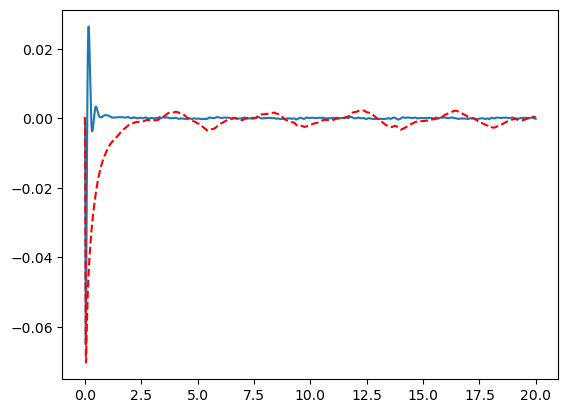

In [16]:
ek = np.array([[0,0,0]])
ak = np.array([[0,0,0]])
akp = np.array([[0,0,0]])
t = []
x = []
x1 = []
x2 = []
x3 = []
x4 = []
x5 = []
x6 = []
x1_r = []
x3_r = []
x5_r = []
e1 = []
e3 = []
e5 = []
ek1 = []
ek3 = []
ek5 = []
xdf = np.array([[0],[0],[0]])
xd = np.array([[0],[0],[0]])
vd = np.array([[0],[0],[0]])
ad = np.array([[0],[0],[0]])
# condiciones iniciales
ti = 0
xi = np.array([[0],[0],[0],[0],[0],[0]])

for i in range(n):
    # generador de trayectorias
    xdi = np.array([[2*np.sin(1.5*ti)],[2*np.cos(1.5*ti)],[2]])
    #xdi = np.array([[0],[1],[2]])
    xd,vd,ad,xdf = gen_trayectorias(xdi,xdf,xd,vd,ad,dt)
    x1_r.append(xd[0,0])
    x3_r.append(xd[1,0])
    x5_r.append(xd[2,0])

    # accion de control
    e = xd - np.array([[xi[0,0]],[xi[2,0]],[xi[4,0]]])
    ep = vd - np.array([[xi[1,0]],[xi[3,0]],[xi[5,0]]])
    e1.append(e[0,0])
    e3.append(e[1,0])
    e5.append(e[2,0])
    ekp = np.array([[e[0,0],e[1,0],e[2,0]]])
    ek1.append(ek_1[i-1,0])
    ek3.append(ek_1[i-1,1])
    ek5.append(ek_1[i-1,2])
    ek = np.concatenate((ek,ekp))
    # ILC
    if i > n-5:
        akp = ILC2(ek_1[i,:],np.array([[0,0,0]]),np.array([[0,0,0]]),np.array([[0,0,0]]),np.array([[0,0,0]]),np.array([[0,0,0]]),ak_1[i,:],akp,dt)
    else:
        akp = ILC2(ek_1[i,:],ek_1[i+1,:],ek_1[i+2,:],ek_1[i+3,:],ek_1[i+4,:],ek_1[i+5,:],ak_1[i,:],akp,dt)
    ak = np.concatenate((ak,akp))
    # CTC
    tau = CTC(e+akp.transpose(),ep,ad,xi)

    # Euler mejorado
    xp = xi + dt*sistema(xi,p[i,:],tau)
    xc = xi + dt/2*(sistema(xi,p[i,:],tau)+sistema(xp,p[i,:],tau))
    
    t.append(ti)
    x1.append(xc[0,0])
    x2.append(xc[1,0])
    x3.append(xc[2,0])
    x4.append(xc[3,0])
    x5.append(xc[4,0])
    x6.append(xc[5,0])
    ti = ti + dt
    xi = xc

ek_1 = ek
ak_1 = ak

#plt.plot(t,x1_r,t,x1,t,e1)
#plt.plot(t,x3_r,t,x3,t,e3)
#plt.plot(t,x5_r,t,x5,t,e5)
plt.plot(t,e1,t,ek1_o,'r--')

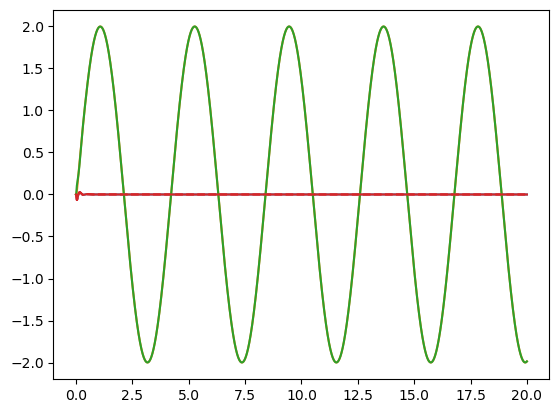

In [18]:
plt.plot(t,e1,t,ek1,'r--')
plt.plot(t,x1_r,t,x1,t,e1)

In [11]:
ek1_o = ek1
ek3_o = ek3
ek5_o = ek5